In [1]:
# llm_groq.py
import os
from dotenv import load_dotenv
from langchain_groq import ChatGroq  # ✅ official LangChain-Groq integration

# Load environment variables
load_dotenv()

# Initialize LLM
model = ChatGroq(
    model="llama-3.3-70b-versatile",  # or llama3-70b-8192, mixtral-8x7b-32768
    temperature=0.7,
    groq_api_key=os.getenv("GROQ_API_KEY"),
)

# Query the model
response = model.invoke("Explain binary search in simple terms.")
print(response.content)

**Binary Search: A Simple Explanation**

Binary search is a method used to find an item in a sorted list. Here's how it works:

1. **Start with a sorted list**: The list must be in order, either from smallest to largest or vice versa.
2. **Find the middle**: Look at the middle item of the list.
3. **Compare the target**: Compare the middle item to the item you're looking for (the target).
4. **Eliminate half**: If the target is smaller than the middle item, eliminate the second half of the list. If the target is larger, eliminate the first half.
5. **Repeat steps 2-4**: Continue finding the middle of the remaining list and comparing it to the target until you find the target or the list is empty.

**Example:**

Suppose you have a sorted list of numbers: 1, 2, 3, 4, 5, 6, 7, 8, 9

You want to find the number 5.

1. Start with the sorted list: 1, 2, 3, 4, 5, 6, 7, 8, 9
2. Find the middle: The middle item is 5.
3. Compare the target: The target (5) is equal to the middle item, so you've f

In [2]:
from typing import Annotated, TypedDict
from langgraph.graph import StateGraph, START, END
# from langchain_openai import ChatOpenAI
from pydantic import BaseModel, Field
import operator

In [18]:

class EvaluationSchema(BaseModel):
    feedback: str = Field(description="Detailed feedback for the essay")
    score: int = Field(description="Score out of 9", ge=0, le=9)

In [19]:
class IELTSState(TypedDict):
    essay: str
    language_feedback: str
    coherence_feedback: str
    lexical_feedback: str
    grammar_feedback: str
    overall_feedback: str
    individual_scores: Annotated[list[int], operator.add]
    avg_score: float

In [21]:
structured_model = model.with_structured_output(EvaluationSchema)

In [22]:
def evaluate_language(state: IELTSState):
    prompt = f"Evaluate the fluency and vocabulary of the following IELTS essay and assign a score out of 9:\n\n{state['essay']}"
    output = structured_model.invoke(prompt)
    return {"language_feedback": output.feedback, "individual_scores": [output.score]}

In [23]:
def evaluate_coherence(state: IELTSState):
    prompt = f"Evaluate the coherence and cohesion of the following IELTS essay and assign a score out of 9:\n\n{state['essay']}"
    output = structured_model.invoke(prompt)
    return {"coherence_feedback": output.feedback, "individual_scores": [output.score]}

In [24]:
def evaluate_lexical(state: IELTSState):
    prompt = f"Evaluate the lexical resource (word choice, variety, precision) of the following IELTS essay and assign a score out of 9:\n\n{state['essay']}"
    output = structured_model.invoke(prompt)
    return {"lexical_feedback": output.feedback, "individual_scores": [output.score]}

In [ ]:

def evaluate_grammar(state: IELTSState):
    prompt = f"Evaluate the grammatical range and accuracy of the following IELTS essay and assign a score out of 9:\n\n{state['essay']}"
    output = structured_model.invoke(prompt)
    return {"grammar_feedback": output.feedback, "individual_scores": [output.score]}

In [25]:
def final_evaluation(state: IELTSState):
    # Summarize all feedback
    prompt = f"""
    Based on the following IELTS feedbacks, generate an overall feedback summary:

    - Language: {state.get("language_feedback", "")}
    - Coherence: {state.get("coherence_feedback", "")}
    - Lexical Resource: {state.get("lexical_feedback", "")}
    - Grammar: {state.get("grammar_feedback", "")}
    """
    overall_feedback = model.invoke(prompt).content

    # Compute average score
    avg_score = sum(state["individual_scores"]) / len(state["individual_scores"])
    return {"overall_feedback": overall_feedback, "avg_score": avg_score}

In [12]:
graph = StateGraph(IELTSState)

# Add nodes
graph.add_node("evaluate_language", evaluate_language)
graph.add_node("evaluate_coherence", evaluate_coherence)
graph.add_node("evaluate_lexical", evaluate_lexical)
graph.add_node("evaluate_grammar", evaluate_grammar)
graph.add_node("final_evaluation", final_evaluation)

# Add edges
graph.add_edge(START, "evaluate_language")
graph.add_edge(START, "evaluate_coherence")
graph.add_edge(START, "evaluate_lexical")
graph.add_edge(START, "evaluate_grammar")

graph.add_edge("evaluate_language", "final_evaluation")
graph.add_edge("evaluate_coherence", "final_evaluation")
graph.add_edge("evaluate_lexical", "final_evaluation")
graph.add_edge("evaluate_grammar", "final_evaluation")

graph.add_edge("final_evaluation", END)

# Compile the workflow
workflow = graph.compile()


In [26]:
essay = """
In recent years, road safety has become a pressing issue worldwide. Some individuals argue that raising the minimum age for driving vehicles would reduce traffic accidents. While age may influence driving behavior, I believe that this measure alone is insufficient and that broader education and enforcement strategies would be more effective.

On one hand, it is understandable why some people advocate for increasing the driving age. Younger drivers often lack experience and may be more prone to reckless behavior. For example, statistics consistently show that road accidents are more frequent among teenagers due to risk-taking and poor decision-making. Therefore, setting a higher age limit could, to some extent, ensure that drivers possess greater maturity and responsibility before operating a vehicle.

However, age does not necessarily determine one’s ability to drive safely. Many accidents are caused by distractions, alcohol consumption, or inadequate traffic education, factors that affect people of all ages. A more sustainable solution would be to enhance driving education and impose stricter penalties for traffic violations. Comprehensive training programs focusing on defensive driving and hazard awareness could significantly reduce accidents. Furthermore, integrating technology such as automatic braking systems or lane-departure warnings could also play a vital role in improving road safety.

In conclusion, although raising the driving age may provide minor benefits, it is not a comprehensive solution. Governments should prioritize driver education, technological improvements, and stricter law enforcement to ensure safer roads for everyone.
"""

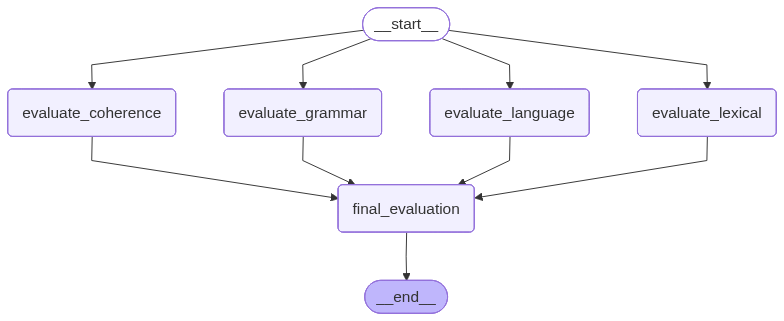

In [28]:
workflow

In [27]:
intial_state = {
    'essay': essay
}

workflow.invoke(intial_state)

{'essay': '\nIn recent years, road safety has become a pressing issue worldwide. Some individuals argue that raising the minimum age for driving vehicles would reduce traffic accidents. While age may influence driving behavior, I believe that this measure alone is insufficient and that broader education and enforcement strategies would be more effective.\n\nOn one hand, it is understandable why some people advocate for increasing the driving age. Younger drivers often lack experience and may be more prone to reckless behavior. For example, statistics consistently show that road accidents are more frequent among teenagers due to risk-taking and poor decision-making. Therefore, setting a higher age limit could, to some extent, ensure that drivers possess greater maturity and responsibility before operating a vehicle.\n\nHowever, age does not necessarily determine one’s ability to drive safely. Many accidents are caused by distractions, alcohol consumption, or inadequate traffic education